In [19]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the transformations: resize, random horizontal flip, convert to tensor, and normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset_path = './Dataset1/ColorectalCancer'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [21]:
import torch.nn as nn
from torchvision import models

# Define a custom ResNet-18 model
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomResNet18, self).__init__()
        resnet = models.resnet18(pretrained=False)  
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Exclude the final classification layer
        self.classifier = nn.Linear(resnet.fc.in_features, num_classes) 

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

model = CustomResNet18(num_classes=3).to(device)


C:\Users\ClementXu\anaconda3\envs\myenv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Train Loss: 0.6382, Train Acc: 74.06%, Test Loss: 1.1237, Test Acc: 53.21%
Epoch [2/10], Train Loss: 0.3732, Train Acc: 85.88%, Test Loss: 0.4766, Test Acc: 81.85%
Epoch [3/10], Train Loss: 0.3020, Train Acc: 88.38%, Test Loss: 1.0913, Test Acc: 65.95%
Epoch [4/10], Train Loss: 0.2284, Train Acc: 91.31%, Test Loss: 0.4350, Test Acc: 84.10%
Epoch [5/10], Train Loss: 0.2000, Train Acc: 92.42%, Test Loss: 0.3912, Test Acc: 88.68%
Epoch [6/10], Train Loss: 0.1697, Train Acc: 93.90%, Test Loss: 0.2381, Test Acc: 90.51%
Epoch [7/10], Train Loss: 0.1575, Train Acc: 94.10%, Test Loss: 0.5702, Test Acc: 80.60%
Epoch [8/10], Train Loss: 0.1208, Train Acc: 95.85%, Test Loss: 0.0884, Test Acc: 96.59%
Epoch [9/10], Train Loss: 0.1136, Train Acc: 95.85%, Test Loss: 0.1755, Test Acc: 94.67%
Epoch [10/10], Train Loss: 0.1135, Train Acc: 95.96%, Test Loss: 0.1934, Test Acc: 92.42%
Final feature model saved.


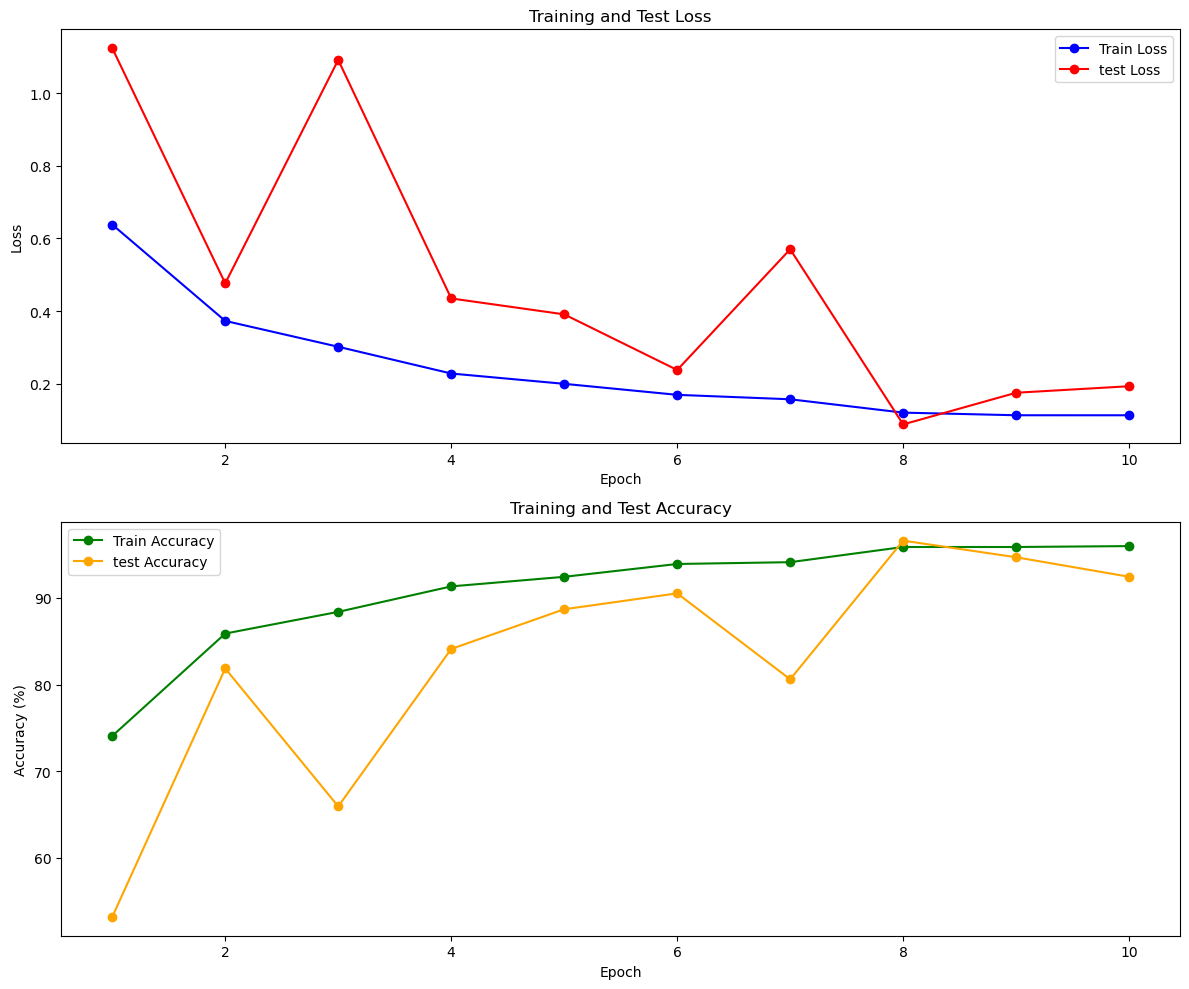

In [22]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training settings
num_epochs = 10
train_losses, train_accuracies=[],[]
test_losses, test_accuracies=[],[]

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= train_total
   
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # test
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_loss /= test_total
    
    scheduler.step(test_loss)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")




# torch.save(model.state_dict(), 'final_custom_resnet18.pth')
# print("Final model saved.")
# Save the final model and the features extracted by it
torch.save(model.features.state_dict(), 'final_feature_resnet18.pth')
print("Final feature model saved.")

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b', label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, marker='o', color='r', label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='g', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', color='orange', label='test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


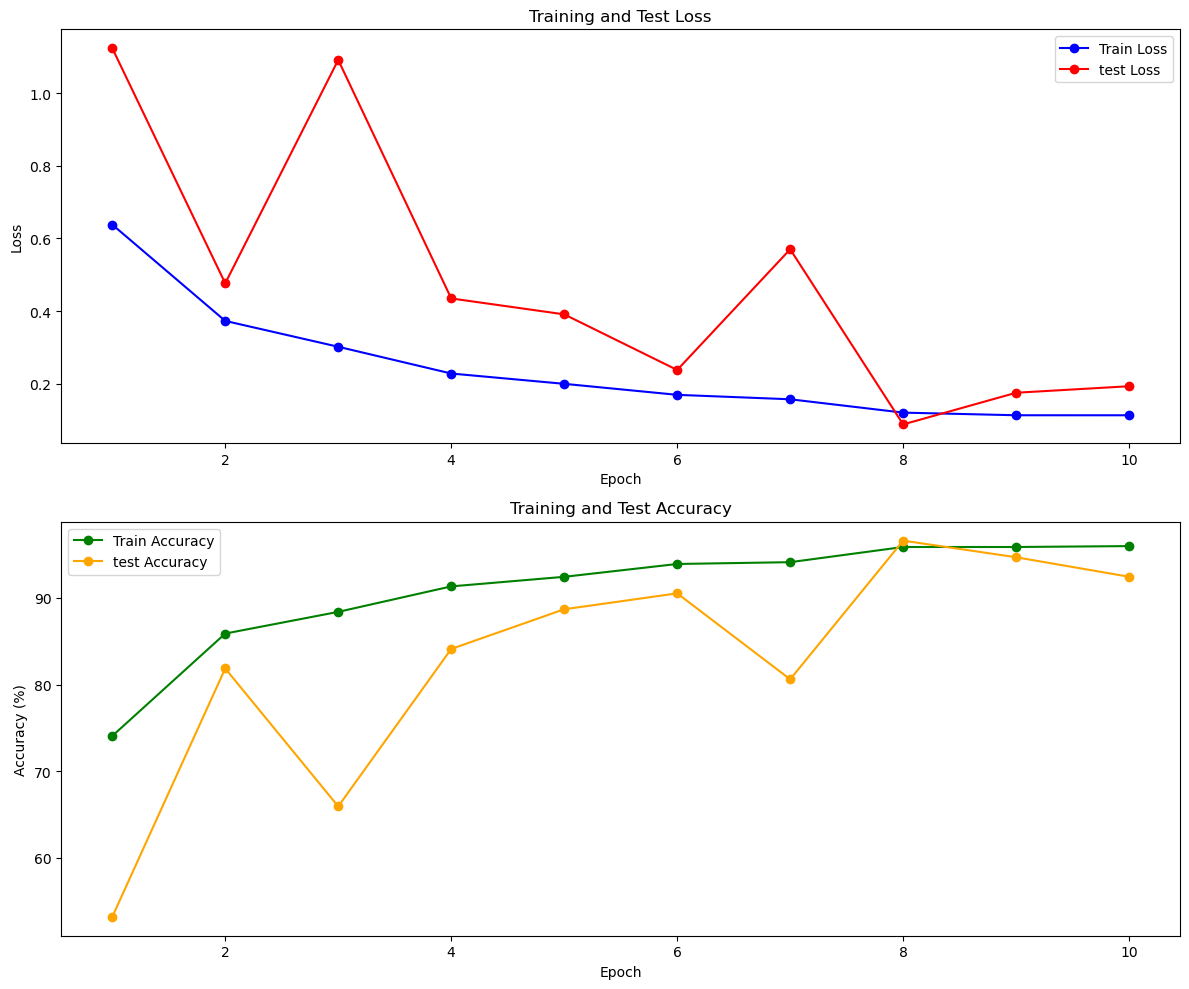

In [23]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b', label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, marker='o', color='r', label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='g', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', color='orange', label='test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

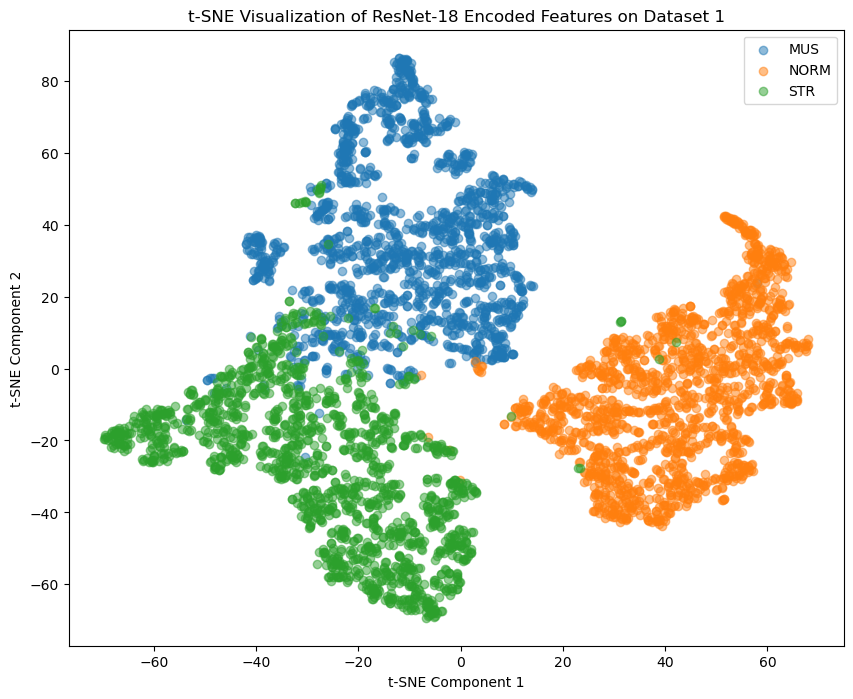

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Function to extract features using the model's encoder
def extract_features(data_loader, model):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, label in data_loader:
            images = images.to(device)
            output = model.features(images)
            features.append(output.view(output.size(0), -1).cpu().numpy())
            labels.append(label.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels


train_features, train_labels = extract_features(train_loader, model)
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(train_features)

# Plot t-SNE visualization of the encoded features
plt.figure(figsize=(10, 8))
for label in np.unique(train_labels):
    idx = train_labels == label
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=dataset.classes[label], alpha=0.5)
plt.legend()
plt.title("t-SNE Visualization of ResNet-18 Encoded Features on Dataset 1")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues", xticks_rotation="horizontal")
    plt.title(title)
    plt.show()

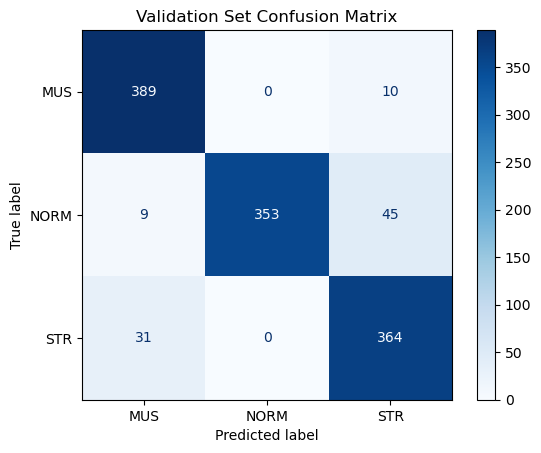

In [28]:
# Validation with Confusion Matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
test_loss /= test_total

# Generate Confusion Matrix
plot_confusion_matrix(
    y_true=all_labels, 
    y_pred=all_predictions, 
    classes=dataset.classes, 
    title="Validation Set Confusion Matrix"
)

In [29]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_predictions, target_names=dataset.classes))

              precision    recall  f1-score   support

         MUS       0.91      0.97      0.94       399
        NORM       1.00      0.87      0.93       407
         STR       0.87      0.92      0.89       395

    accuracy                           0.92      1201
   macro avg       0.93      0.92      0.92      1201
weighted avg       0.93      0.92      0.92      1201

